# Vehicle Classification

In [ ]:
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

True

In [2]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
if IN_COLAB:
    # Put here the full path to the folder having your Sprint project code
    # e.g. "/content/drive/MyDrive/assignment"
    ROOT_DIR = "/content/drive/MyDrive/assignment"
    %cd $ROOT_DIR

/content/drive/MyDrive/assignment


## Install dependencies (Only for Colab)

In [4]:
if IN_COLAB:
    # This will make sure you have installed all the proper dependencies
    # Instal dependencies
    !pip install -r requirements.txt
    # We can access to GPUs in Colab, so install GPU version of tensorflow
    !pip install tensorflow-gpu==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.8 MB/s eta 0:00:00


## 1. Introduction

This is a Multi-class Classification task: we want to predict, given a picture of a vehicle, which of the possible 25 classes is the correct vehicle make-model.

The dataset is composed of JPG images, already stored in folders containing the label (vehicle make-model), separated in train and test sets.


In [5]:
import os

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from src import data_utils, models, config

### Getting the data

To access the data for this project, you only need to execute the code below. This will download a zip file `cars_25_dataset.zip` containing inside:

- `car_ims_dataset`: Folder whit train and test images, already classified in sub-folders with the corresponding vehicle label.

- `train_dataset_annos.csv` and `test_dataset_annos.csv`: Train and test images annotations provided in CSV file format. You will not need these files unless you want to solve the optional exercises.


1.1. Download the training and test datasets.

In [6]:
if IN_COLAB:
    config.DATASET_ROOT_PATH = "/content/dataset/"

data_utils.download_datasets(config.DATASET_ROOT_PATH)

Downloading...
From: https://drive.google.com/uc?id=1ueaI8NJLS73Eq8Kx9ctdy5hK3vD53_Jb&confirm=t
To: /content/dataset/cars_25_dataset.zip
100%|██████████| 116M/116M [00:00<00:00, 125MB/s] 


1.2. Setup some variables you will use during training the model.

The default values used here should work fine for you.

In [7]:
# Dataset folder
DATASET_FOLDER = os.path.join(config.DATASET_ROOT_PATH, config.DATASET_FILENAME)
DATASET_FOLDER = os.path.join(config.DATASET_ROOT_PATH, "eu-car-dataset_subset")

img_height = 224
img_width = 224
batch_size = 32

1.3. Load the training and testing images as a Tensorflow dataset (`tf.data.Dataset`).

Note that it's not a good idea to load all the images into memory because they may need more RAM than the one installed in the system. This is why we create generators using the `image_dataset_from_directory()` function, which loads the images only when they are needed and then releases the memory for loading another batch of new images from the disk.


**Don't change anything in this cell, just make it run correctly**

In [8]:
# Load train and test datasets
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(DATASET_FOLDER, "train"),
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(DATASET_FOLDER, "test"),
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 7509 files belonging to 25 classes.
Found 1875 files belonging to 25 classes.


**Checkpoint:** The cell above should output the following message:

```code
Found 7509 files belonging to 25 classes.
Found 1875 files belonging to 25 classes.
```

## 2. Basic EDA

Let's load and display some pictures with their labels.


2.1. Take the class names automatically inferred from the data generator and assign to `class_names` variable. We will use this to do some EDA and also to define the output units in the classification layer of our model.


**Don't change anything in this cell, just make it run correctly**

In [9]:
class_names = train_ds.class_names
print(class_names)

assert len(class_names) == 25

['abarth_595-turismo', 'abarth_grande-punto', 'bmw_z4', 'citroen_c-crosser', 'citroen_ds4', 'citroen_nemo', 'dacia_lodgy', 'ford_f-150', 'hyundai_h-350', 'hyundai_i30', 'land-rover_range-rover-velar', 'mercedes-benz_180', 'mercedes-benz_a-180', 'mercedes-benz_b-220', 'mercedes-benz_cla-220', 'mercedes-benz_cls-320', 'mercedes-benz_slk-350', 'mini_cooper-sd', 'nissan_nv400', 'nissan_primastar', 'peugeot_108', 'porsche_991', 'suzuki_ignis', 'volkswagen_fox', 'volkswagen_up!']


2.2. Let's show some pictures!

You can re-run the following cell as many times as you want and it will always show a new set of images and labels.

**Don't change anything in this cell, just make it run correctly**

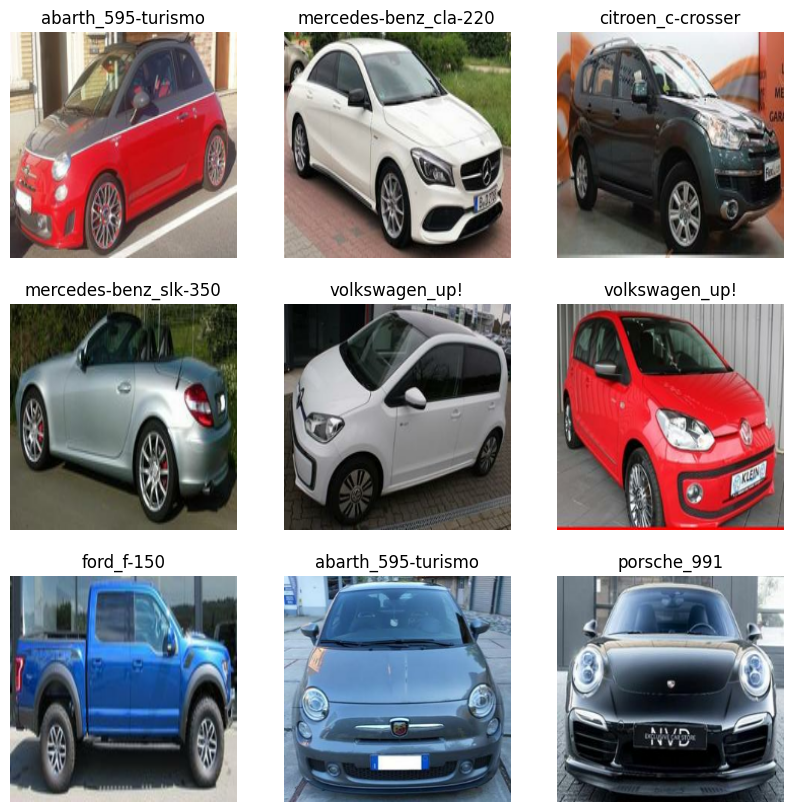

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

**Don't change anything in this cell, just make it run correctly**

In [11]:
# Configure data loader for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 3. Multi-layer Perceptron

*Now it's time to train our first Neural Network model. For simplicity, we are going to try using an MLP model.*

*A Multi-layer Perceptron (MLP) is a simple neural network consisting of multiple layers of nodes connected by weighted edges. The input and output layers have one node per feature, and one node per target class respectively, while the intermediate layers have an arbitrary number of nodes. MLPs are known to work well for simple classification tasks, but they might not be suitable for image classification, where the input data has a high dimensionality and there are correlations between adjacent pixels.*

---

Executing the following cell will create a model using the `create_mlp_model()` functions you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_mlp_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


In [12]:
mlp_model = models.create_mlp_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Compile the model
mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

mlp_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=30,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 512)               77070848  
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 25)                12825     
                                                                 
Total params: 78,133,785
Trainable params: 78,133,785
No

At this point the model accuracy in the validation dataset should be around *0.3*.

What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?

What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?

## 4. CNN: LeNet

*Multi-layer Perceptrons are known to work well for simple classification tasks, but they might not be suitable for image classification, where the input data has a high dimensionality and there are correlations between adjacent pixels.*

*If the previous model wasn't enough for the accuracy we aim to achieve, we can try a bigger one, a Convolutional Network! We are going to use the first develop CNN, the LeNet model.*

*LeNet is a type of Convolutional Neural Network (CNN) that was specifically designed for image classification. LeNet uses a set of convolutional layers to extract low-level features such as edges and corners, and then combines them into higher-level features through a series of pooling layers. Finally, a set of fully connected layers is used to classify the images. LeNet has shown to be very effective in image classification tasks, especially in cases where the input images are small and the features are not too complex.*

---

Executing the following cell will create a model using the `create_lenet_model()` function you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_lenet_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


In [13]:
lenet_model = models.create_lenet_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Compile the model
lenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

lenet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 average_pooling2d (AverageP  (None, 111, 111, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 average_pooling2d_1 (Averag  (None, 54, 54, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 46656)            

At this point the model accuracy in the validation dataset should be around *0.3*.

What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?

What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?

## 5. CNN: Transfer learning from ResNet50

*Maybe the LeNet is still no the best choice for our task. Actually, most of the time, when solving image classification problems, the best results are achieved using pre-built CNN architecture pre-trained on imagenet dataset. This process is commonly known as **transfer learning** or **fine-tuning**.*

*ResNet50, is a much deeper CNN that was developed to tackle the problem of vanishing gradients in deep neural networks. ResNet50 is made up of many layers that are organized into blocks, each of which has a set of convolutional layers followed by shortcut connections that allow for the easy flow of information between layers. These shortcut connections help to prevent vanishing gradients and allow the network to learn very deep representations of the input images. This makes ResNet50 ideal for image classification tasks where the input images are complex and large.*

*Therefore, it would be better to use ResNet50 finetuning for image classification tasks, especially if the input images are complex and large, as it has been optimized for this specific task and has shown to be very effective in achieving state-of-the-art results. Additionally, using ResNet50 finetuning means that the model can take advantage of the pre-trained weights on a large dataset, which can lead to faster convergence and better performance on smaller datasets.*

---

Executing the following cell will create a model using the `create_resnet50_model()` function you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_resnet50_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


In [41]:
from tensorflow.keras.applications.resnet import preprocess_input

train_ds_preprocessed = train_ds.map(lambda x, y: (preprocess_input(x), y))

# Preprocess the test dataset using ResNet preprocessing
test_ds_preprocessed = test_ds.map(lambda x, y: (preprocess_input(x), y))


resnet50_model = models.create_resnet50_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Compile the model
resnet50_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

resnet50_model.fit(
    train_ds_preprocessed,
    validation_data=test_ds_preprocessed,
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(
            patience=10,
            restore_best_weights=True,
        )
    ],
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_1 (Dropout)         (None, 100352)            0         
                                                                 
 dense_8 (Dense)             (None, 25)                2508825   
                                                                 
Total params: 26,096,537
Trainable params: 2,508,825
Non-trainable params: 23,587,712
_________________________________________________________________
None
Epoch 1/20
235/235 [==============================] - 41s 159ms/step - loss: 5.4047 - accuracy: 0.0726 - val_loss: 3.2240 - val_accuracy: 0.1664
Epoch 2/20
235/2

At this point the model accuracy in the validation dataset should be around *0.7*.

What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?

What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?

## 6. Analyze model results

Choose your best model and report some metrics on the results you obtained.

You can plot a confussion matrix or use [Scikit-learn classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).


In [42]:
y_pred = resnet50_model.predict(test_ds)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = tf.concat([y for x, y in test_ds], axis = 0).numpy()
true_categories_argmax = np.argmax(true_categories, axis = 1)

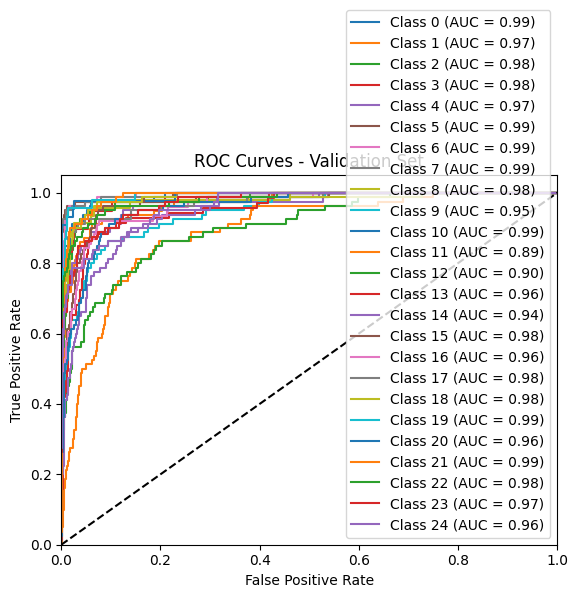

In [43]:

fpr_val = {}
tpr_val = {}
roc_auc_val = {}
for class_idx in range(25):
    fpr, tpr, _ = roc_curve(true_categories[:, class_idx], y_pred[:, class_idx])
    roc_auc = auc(fpr, tpr)
    fpr_val[i] = fpr
    tpr_val[i] = tpr
    roc_auc_val[i] = roc_auc

    plt.plot(fpr, tpr, label=f'Class {class_idx} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Validation Set')
plt.legend(loc="lower right")
plt.show()


In [44]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
print(classification_report(true_categories_argmax, predicted_categories))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        80
           1       0.77      0.62      0.69        78
           2       0.63      0.84      0.72        80
           3       0.65      0.83      0.73        77
           4       0.66      0.78      0.71        80
           5       0.74      0.95      0.83        80
           6       0.87      0.85      0.86        80
           7       0.96      0.89      0.92        80
           8       0.89      0.67      0.77        46
           9       0.80      0.44      0.56        80
          10       0.91      0.91      0.91        43
          11       0.33      0.47      0.39        80
          12       0.60      0.38      0.46        80
          13       0.58      0.52      0.55        69
          14       0.48      0.49      0.48        80
          15       0.55      0.72      0.62        80
          16       0.85      0.37      0.51        76
          17       0.79    

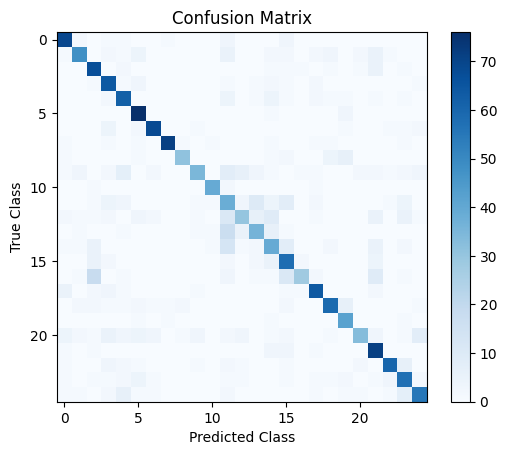

In [45]:
confusion_mat = confusion_matrix(true_categories_argmax, predicted_categories)

# Plot the confusion matrix as a heatmap
plt.figure()
plt.imshow(confusion_mat, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

## 7. Optional. Make your own model

The models we've trained before are just a limited set over the universe of stuff you can use.

You still have a lot of things to experiment with to increase accuracy, some ideas are:

1. Use any other CNN architecture you think may perform better than ResNet50.
2. Try adding data augmentation or any other regularization algorithms.
3. Train using more epochs, a different optimization algorithm, etc.
4. Check [KerasTuner](https://keras.io/api/keras_tuner/) documentation about how to efficiently test a lot of different architectures and parameters.

In [64]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [71]:


# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)


valid_datagen = ImageDataGenerator()



In [72]:


# Create the EfficientNet model
base_model = EfficientNetB1(include_top=False, input_shape=(240, 240, 3), weights='imagenet')
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(25, activation='softmax')
])

In [73]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



In [74]:

# Set the number of epochs and batch size
epochs = 10
batch_size = 32


In [75]:

# Generate augmented training data
train_generator = datagen.flow_from_directory(
    os.path.join(DATASET_FOLDER, "train"),
    target_size=(240, 240),
    batch_size=batch_size,
    class_mode='categorical'
)


validation_generator = valid_datagen.flow_from_directory(
    os.path.join(DATASET_FOLDER, "test"),
    target_size=(240, 240),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 7509 images belonging to 25 classes.
Found 1875 images belonging to 25 classes.


In [76]:
# Train the model with data augmentation
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size
)




Epoch 1/10
234/234 [==============================] - 224s 882ms/step - loss: 1.4527 - accuracy: 0.5726 - val_loss: 0.8380 - val_accuracy: 0.7484
Epoch 2/10
234/234 [==============================] - 201s 859ms/step - loss: 0.5721 - accuracy: 0.8239 - val_loss: 0.6891 - val_accuracy: 0.7974
Epoch 3/10
234/234 [==============================] - 204s 873ms/step - loss: 0.3981 - accuracy: 0.8778 - val_loss: 0.3786 - val_accuracy: 0.8766
Epoch 4/10
234/234 [==============================] - 203s 865ms/step - loss: 0.3251 - accuracy: 0.8959 - val_loss: 0.4709 - val_accuracy: 0.8502
Epoch 5/10
234/234 [==============================] - 204s 872ms/step - loss: 0.3068 - accuracy: 0.9020 - val_loss: 0.5011 - val_accuracy: 0.8481
Epoch 6/10
234/234 [==============================] - 201s 857ms/step - loss: 0.2677 - accuracy: 0.9113 - val_loss: 0.4465 - val_accuracy: 0.8723
Epoch 7/10
234/234 [==============================] - 203s 867ms/step - loss: 0.2241 - accuracy: 0.9255 - val_loss: 0.4713 -

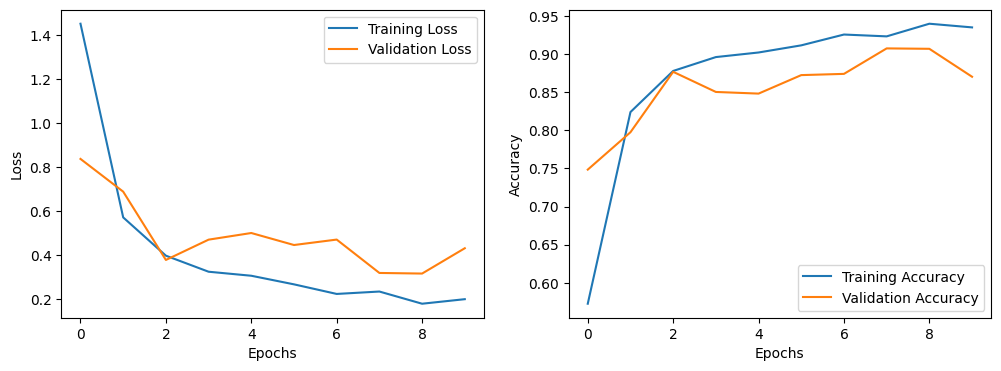

In [77]:

# Plot the loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

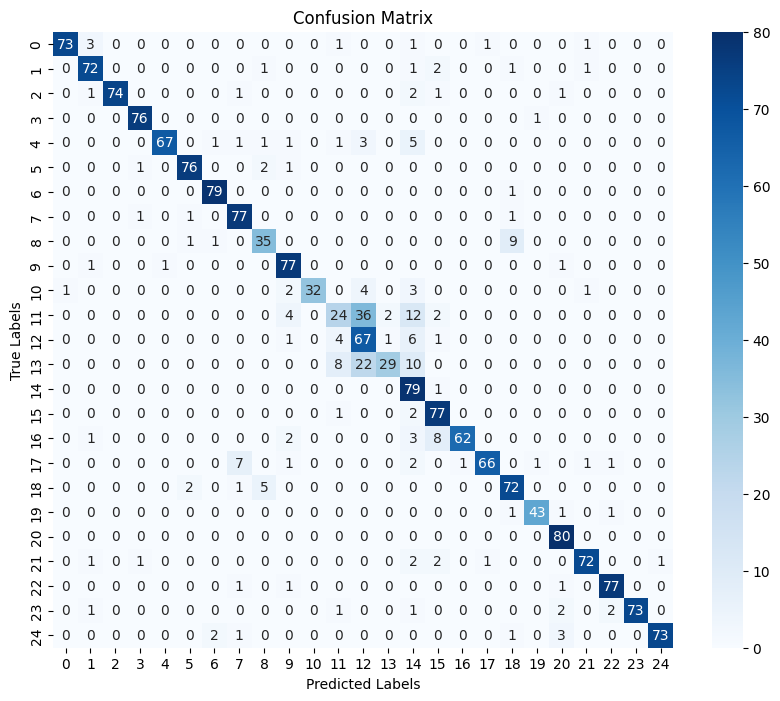

              precision    recall  f1-score   support

           0       0.99      0.91      0.95        80
           1       0.90      0.92      0.91        78
           2       1.00      0.93      0.96        80
           3       0.96      0.99      0.97        77
           4       0.99      0.84      0.91        80
           5       0.95      0.95      0.95        80
           6       0.95      0.99      0.97        80
           7       0.87      0.96      0.91        80
           8       0.80      0.76      0.78        46
           9       0.86      0.96      0.91        80
          10       1.00      0.74      0.85        43
          11       0.60      0.30      0.40        80
          12       0.51      0.84      0.63        80
          13       0.91      0.42      0.57        69
          14       0.61      0.99      0.76        80
          15       0.82      0.96      0.89        80
          16       0.98      0.82      0.89        76
          17       0.97    

In [86]:
import seaborn as sns
y_pred = model.predict(validation_generator)
predicted_categories = np.argmax(y_pred, axis=1)
true_categories = validation_generator.classes

# Generate confusion matrix
confusion_mat = confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
classification_report = classification_report(true_categories, predicted_categories)
print(classification_report)

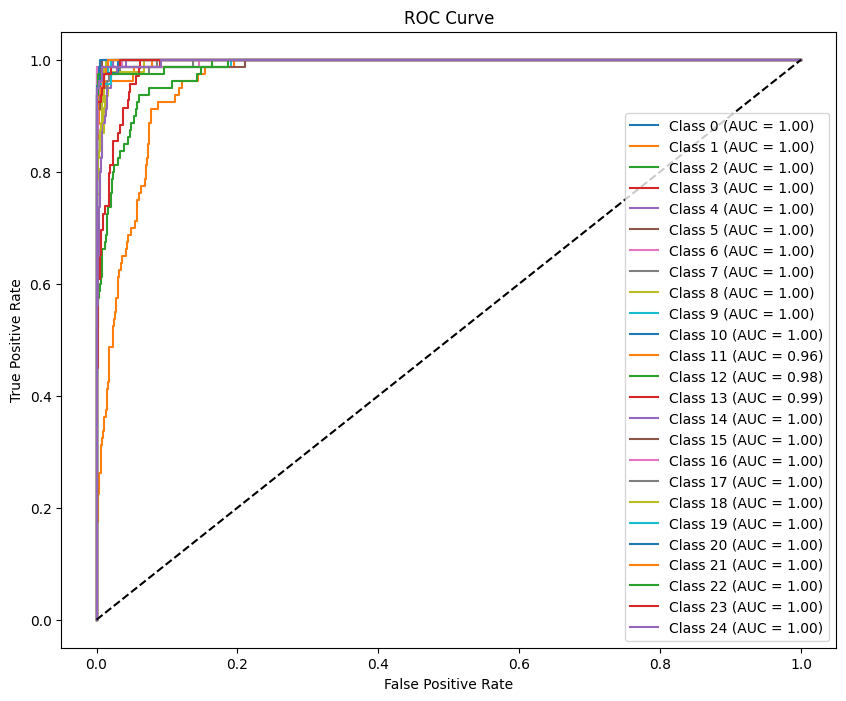

In [97]:
from sklearn.metrics import roc_curve, auc

# Generate predictions
y_pred = model.predict(validation_generator)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Get the true labels from the validation generator
y_true = validation_generator.labels

# Convert the true labels to one-hot encoded format
n_classes = validation_generator.num_classes
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)

# Compute ROC curve and ROC AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {0} (AUC = {1:.2f})'.format(i, roc_auc[i]))

# Plot the random classifier line
plt.plot([0, 1], [0, 1], 'k--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Display legend
plt.legend(loc='lower right')

# Show the plot
plt.show()
